In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler


# Heating Oil

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('Heating Oil Futures Historical Data.csv').dropna()

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)


In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,2.5986,2.6109,2.6172,2.5884,20.97K,-0.88%
1,2024-03-26,2.6218,2.6845,2.6870,2.6097,24.09K,-2.12%
2,2024-03-25,2.6786,2.6644,2.7062,2.6533,29.06K,0.95%
3,2024-03-22,2.6534,2.6630,2.6904,2.6471,27.59K,-0.58%
4,2024-03-21,2.6688,2.6932,2.7026,2.6360,24.85K,-1.00%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,1.7006,1.6895,1.7489,1.6424,65510,0.89
1,2019-01-03,1.7420,1.7008,1.7466,1.6801,56550,2.43
2,2019-01-04,1.7692,1.7300,1.8035,1.7236,61140,1.56
3,2019-01-07,1.7784,1.7809,1.8245,1.7764,57180,0.52
4,2019-01-08,1.8270,1.7810,1.8296,1.7757,57590,2.73
...,...,...,...,...,...,...,...
1314,2024-03-21,2.6688,2.6932,2.7026,2.6360,24850,-1.00
1315,2024-03-22,2.6534,2.6630,2.6904,2.6471,27590,-0.58
1316,2024-03-25,2.6786,2.6644,2.7062,2.6533,29060,0.95
1317,2024-03-26,2.6218,2.6845,2.6870,2.6097,24090,-2.12


In [7]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [9]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [10]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])



In [11]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [13]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.2379809093561638
MAPE trên tập test là: 6.344213271199265 %
MAE trên tập test là: 0.1828816613333332


In [14]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



[[2.756995]
 [2.780655]
 [2.795099]
 [2.815626]
 [2.798797]
 [2.803671]
 [2.798604]
 [2.833164]
 [2.877259]
 [2.870596]
 [2.874098]
 [2.866186]
 [2.85859 ]
 [2.847504]
 [2.859851]
 [2.879088]
 [2.868773]
 [2.871732]
 [2.886786]
 [2.941319]
 [3.118859]
 [3.107489]
 [3.153879]
 [3.154688]
 [3.319369]
 [3.335388]
 [3.355496]
 [3.369526]
 [3.3671  ]
 [3.373505]]


In [15]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1319,2.756995
1320,2.780655
1321,2.795099
1322,2.815626
1323,2.798797
1324,2.803671
1325,2.798604
1326,2.833164
1327,2.877259
1328,2.870596


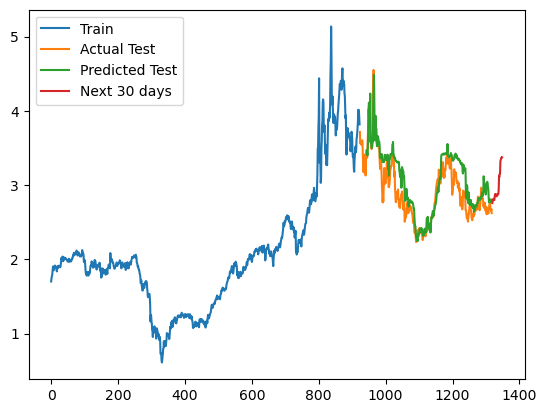

In [16]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.savefig('Heating_Oil_73_Fix.png') 
plt.legend()
plt.show()


## 8:2

In [17]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [18]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [19]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [21]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07900447493199252
MAPE trên tập test là: 2.2484627598867366 %
MAE trên tập test là: 0.06218088477366251


In [22]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[2.694777]
 [2.723228]
 [2.746616]
 [2.772189]
 [2.805796]
 [2.809199]
 [2.817867]
 [2.837758]
 [2.860375]
 [2.854905]
 [2.834621]
 [2.83635 ]
 [2.838551]
 [2.848994]
 [2.857579]
 [2.852435]
 [2.867056]
 [2.858327]
 [2.853286]
 [2.858796]
 [2.853177]
 [2.847864]
 [2.857726]
 [2.847699]
 [2.862826]
 [2.8584  ]
 [2.85233 ]
 [2.858452]
 [2.846687]
 [2.845682]]


In [23]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1319,2.694777
1320,2.723228
1321,2.746616
1322,2.772189
1323,2.805796
1324,2.809199
1325,2.817867
1326,2.837758
1327,2.860375
1328,2.854905


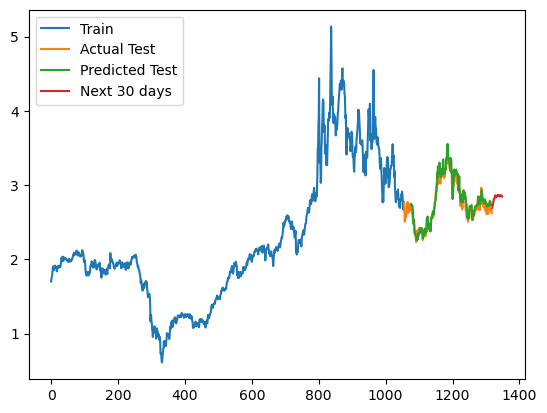

In [24]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

### 9:1

In [25]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [26]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [27]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [29]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06729750830648383
MAPE trên tập test là: 1.8933112751870091 %
MAE trên tập test là: 0.05245880180180168


In [30]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[2.571074]
 [2.550981]
 [2.528501]
 [2.521605]
 [2.516214]
 [2.505043]
 [2.50438 ]
 [2.500858]
 [2.486362]
 [2.495743]
 [2.479763]
 [2.496702]
 [2.480011]
 [2.495312]
 [2.488358]
 [2.504274]
 [2.489741]
 [2.508186]
 [2.490298]
 [2.51181 ]
 [2.498481]
 [2.508745]
 [2.501332]
 [2.504732]
 [2.50475 ]
 [2.4986  ]
 [2.501499]
 [2.499746]
 [2.496833]
 [2.497363]]


In [31]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1319,2.571074
1320,2.550981
1321,2.528501
1322,2.521605
1323,2.516214
1324,2.505043
1325,2.504380
1326,2.500858
1327,2.486362
1328,2.495743


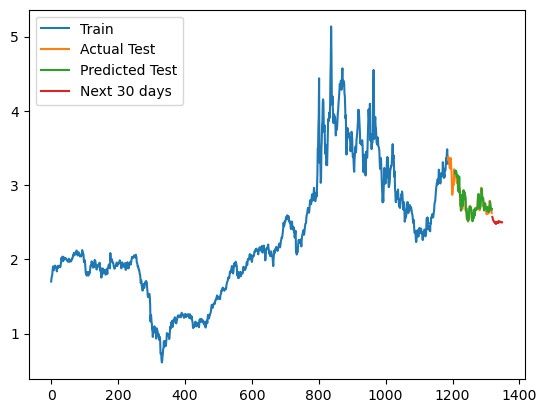

In [32]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()